Imports

In [1]:
#!pip install shap
#!pip install fairlearn
#!pip install imbalanced-learn
#!pip install seaborn

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel, RFECV
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, confusion_matrix,
    ConfusionMatrixDisplay, classification_report, roc_auc_score)
from sklearn.model_selection import (
    train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer, LabelEncoder)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

from fairlearn.metrics import MetricFrame
from fairlearn.postprocessing import ThresholdOptimizer

from shap import TreeExplainer
from shap import summary_plot as shap_summary_plot

warnings.filterwarnings('ignore', 'Solver terminated early.*')


Loading the Data

In [3]:
df_heart = pd.read_csv('data\heart_2022_with_nans.csv')

In [4]:
df_heart['HadHeartAttack'].value_counts()

HadHeartAttack
No     416959
Yes     25108
Name: count, dtype: int64

In [5]:
df_heart.isna().sum()

State                            0
Sex                              0
GeneralHealth                 1198
PhysicalHealthDays           10927
MentalHealthDays              9067
LastCheckupTime               8308
PhysicalActivities            1093
SleepHours                    5453
RemovedTeeth                 11360
HadHeartAttack                3065
HadAngina                     4405
HadStroke                     1557
HadAsthma                     1773
HadSkinCancer                 3143
HadCOPD                       2219
HadDepressiveDisorder         2812
HadKidneyDisease              1926
HadArthritis                  2633
HadDiabetes                   1087
DeafOrHardOfHearing          20647
BlindOrVisionDifficulty      21564
DifficultyConcentrating      24240
DifficultyWalking            24012
DifficultyDressingBathing    23915
DifficultyErrands            25656
SmokerStatus                 35462
ECigaretteUsage              35660
ChestScan                    56046
RaceEthnicityCategor

In [6]:
#df_heart = df_heart.dropna()
df_heart = df_heart.dropna(subset=['HadHeartAttack'])
df_heart['HadHeartAttack'] = df_heart['HadHeartAttack'].map({'Yes': 1, 'No': 0})

In [7]:
df_heart['HadHeartAttack'].value_counts()

HadHeartAttack
0    416959
1     25108
Name: count, dtype: int64

In [8]:
#sample from dfheart to reduce data
#df_heart = df_heart.sample(1000, random_state=42)#just for testing

In [9]:
df_heart.shape

(442067, 40)

In [10]:
df_heart_eda = df_heart.copy()
#df_heart_eda.drop(['RaceEthnicityCategory','Sex'], axis=1, inplace=True)
#df_heart_eda.drop(['WeightInKilograms','HeightInMeters'], axis=1, inplace=True)
#df_heart_eda.drop(['RemovedTeeth','DeafOrHardOfHearing','BlindOrVisionDifficulty'], axis=1, inplace=True)
#df_heart_eda.drop('State', axis=1, inplace=True)

In [11]:
df_heart_eda.shape

(442067, 40)

In [12]:
df_heart_eda.isna().sum()

State                            0
Sex                              0
GeneralHealth                 1095
PhysicalHealthDays           10597
MentalHealthDays              8792
LastCheckupTime               8041
PhysicalActivities             972
SleepHours                    5196
RemovedTeeth                 11010
HadHeartAttack                   0
HadAngina                     3588
HadStroke                     1070
HadAsthma                     1437
HadSkinCancer                 2764
HadCOPD                       1838
HadDepressiveDisorder         2421
HadKidneyDisease              1614
HadArthritis                  2313
HadDiabetes                    813
DeafOrHardOfHearing          20278
BlindOrVisionDifficulty      21190
DifficultyConcentrating      23795
DifficultyWalking            23604
DifficultyDressingBathing    23513
DifficultyErrands            25231
SmokerStatus                 34941
ECigaretteUsage              35143
ChestScan                    55288
RaceEthnicityCategor

Splitting

In [13]:
train_df, test_df = train_test_split(df_heart_eda, test_size=0.2, random_state=42)

# Separate features and target variable for training data
X_train = train_df.drop(columns=["HadHeartAttack"])
y_train = train_df["HadHeartAttack"]

# Separate features and target variable for testing data
X_test = test_df.drop(columns=["HadHeartAttack"])
y_test = test_df["HadHeartAttack"]

In [14]:
train_df.head()

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
128570,Kansas,Female,Poor,30.0,15.0,Within past year (anytime less than 12 months ...,No,6.0,All,0,...,1.55,93.44,38.92,Yes,Yes,Yes,Yes,"Yes, received Tdap",No,No
243349,New Hampshire,Male,Excellent,0.0,1.0,Within past year (anytime less than 12 months ...,Yes,8.0,None of them,0,...,1.75,74.84,24.37,NaN,No,No,No,"Yes, received tetanus shot but not sure what type",No,Tested positive using home test without a heal...
153410,Maine,Female,Very good,2.0,2.0,Within past year (anytime less than 12 months ...,Yes,8.0,1 to 5,0,...,1.78,72.57,22.96,Yes,No,Yes,Yes,"Yes, received tetanus shot but not sure what type",No,Tested positive using home test without a heal...
37877,Colorado,Female,Excellent,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,NaN,1 to 5,0,...,1.55,NaN,NaN,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No
417623,West Virginia,Male,Good,0.0,30.0,Within past year (anytime less than 12 months ...,Yes,1.0,"6 or more, but not all",0,...,1.75,90.72,29.53,No,No,No,No,NaN,No,No


Exploratory Data Analysis

In [15]:
train_df.columns

Index(['State', 'Sex', 'GeneralHealth', 'PhysicalHealthDays',
       'MentalHealthDays', 'LastCheckupTime', 'PhysicalActivities',
       'SleepHours', 'RemovedTeeth', 'HadHeartAttack', 'HadAngina',
       'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD',
       'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis',
       'HadDiabetes', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty',
       'DifficultyConcentrating', 'DifficultyWalking',
       'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus',
       'ECigaretteUsage', 'ChestScan', 'RaceEthnicityCategory', 'AgeCategory',
       'HeightInMeters', 'WeightInKilograms', 'BMI', 'AlcoholDrinkers',
       'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver', 'TetanusLast10Tdap',
       'HighRiskLastYear', 'CovidPos'],
      dtype='object')

In [16]:
train_df.nunique()

State                          54
Sex                             2
GeneralHealth                   5
PhysicalHealthDays             31
MentalHealthDays               31
LastCheckupTime                 4
PhysicalActivities              2
SleepHours                     24
RemovedTeeth                    4
HadHeartAttack                  2
HadAngina                       2
HadStroke                       2
HadAsthma                       2
HadSkinCancer                   2
HadCOPD                         2
HadDepressiveDisorder           2
HadKidneyDisease                2
HadArthritis                    2
HadDiabetes                     4
DeafOrHardOfHearing             2
BlindOrVisionDifficulty         2
DifficultyConcentrating         2
DifficultyWalking               2
DifficultyDressingBathing       2
DifficultyErrands               2
SmokerStatus                    4
ECigaretteUsage                 4
ChestScan                       2
RaceEthnicityCategory           5
AgeCategory   

In [17]:
train_df.dtypes

State                         object
Sex                           object
GeneralHealth                 object
PhysicalHealthDays           float64
MentalHealthDays             float64
LastCheckupTime               object
PhysicalActivities            object
SleepHours                   float64
RemovedTeeth                  object
HadHeartAttack                 int64
HadAngina                     object
HadStroke                     object
HadAsthma                     object
HadSkinCancer                 object
HadCOPD                       object
HadDepressiveDisorder         object
HadKidneyDisease              object
HadArthritis                  object
HadDiabetes                   object
DeafOrHardOfHearing           object
BlindOrVisionDifficulty       object
DifficultyConcentrating       object
DifficultyWalking             object
DifficultyDressingBathing     object
DifficultyErrands             object
SmokerStatus                  object
ECigaretteUsage               object
C

In [18]:
eda_summary = {
    'info': train_df.info(),
    'describe': train_df.describe(),
    'null_values': train_df.isnull().sum(),
    'class_balance': train_df['HadHeartAttack'].value_counts(normalize=True)
}

eda_summary['info']

<class 'pandas.core.frame.DataFrame'>
Index: 353653 entries, 128570 to 122916
Data columns (total 40 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   State                      353653 non-null  object 
 1   Sex                        353653 non-null  object 
 2   GeneralHealth              352784 non-null  object 
 3   PhysicalHealthDays         345107 non-null  float64
 4   MentalHealthDays           346669 non-null  float64
 5   LastCheckupTime            347191 non-null  object 
 6   PhysicalActivities         352851 non-null  object 
 7   SleepHours                 349517 non-null  float64
 8   RemovedTeeth               344870 non-null  object 
 9   HadHeartAttack             353653 non-null  int64  
 10  HadAngina                  350794 non-null  object 
 11  HadStroke                  352818 non-null  object 
 12  HadAsthma                  352508 non-null  object 
 13  HadSkinCancer              35

In [19]:
eda_summary['describe']

,PhysicalHealthDays,MentalHealthDays,SleepHours,HadHeartAttack,HeightInMeters,WeightInKilograms,BMI
count,345107.000000,346669.000000,349517.000000,353653.000000,331201.000000,320603.00000,315277.000000
mean,4.319243,4.365617,7.023707,0.056852,1.702709,83.07117,28.526586
std,8.654767,8.365401,1.494867,0.231561,0.107168,21.42278,6.544501
min,0.000000,0.000000,1.000000,0.000000,0.910000,22.68000,12.050000
25%,0.000000,0.000000,6.000000,0.000000,1.630000,68.04000,24.130000
50%,0.000000,0.000000,7.000000,0.000000,1.700000,80.74000,27.440000
75%,3.000000,5.000000,8.000000,0.000000,1.780000,95.25000,31.750000
max,30.000000,30.000000,24.000000,1.000000,2.410000,285.00000,99.640000


In [20]:
eda_summary['null_values']

State                            0
Sex                              0
GeneralHealth                  869
PhysicalHealthDays            8546
MentalHealthDays              6984
LastCheckupTime               6462
PhysicalActivities             802
SleepHours                    4136
RemovedTeeth                  8783
HadHeartAttack                   0
HadAngina                     2859
HadStroke                      835
HadAsthma                     1145
HadSkinCancer                 2241
HadCOPD                       1471
HadDepressiveDisorder         1927
HadKidneyDisease              1287
HadArthritis                  1863
HadDiabetes                    666
DeafOrHardOfHearing          16152
BlindOrVisionDifficulty      16900
DifficultyConcentrating      18963
DifficultyWalking            18767
DifficultyDressingBathing    18726
DifficultyErrands            20114
SmokerStatus                 27868
ECigaretteUsage              27978
ChestScan                    44112
RaceEthnicityCategor

In [21]:
eda_summary['class_balance']

HadHeartAttack
0    0.943148
1    0.056852
Name: proportion, dtype: float64

Visualizations

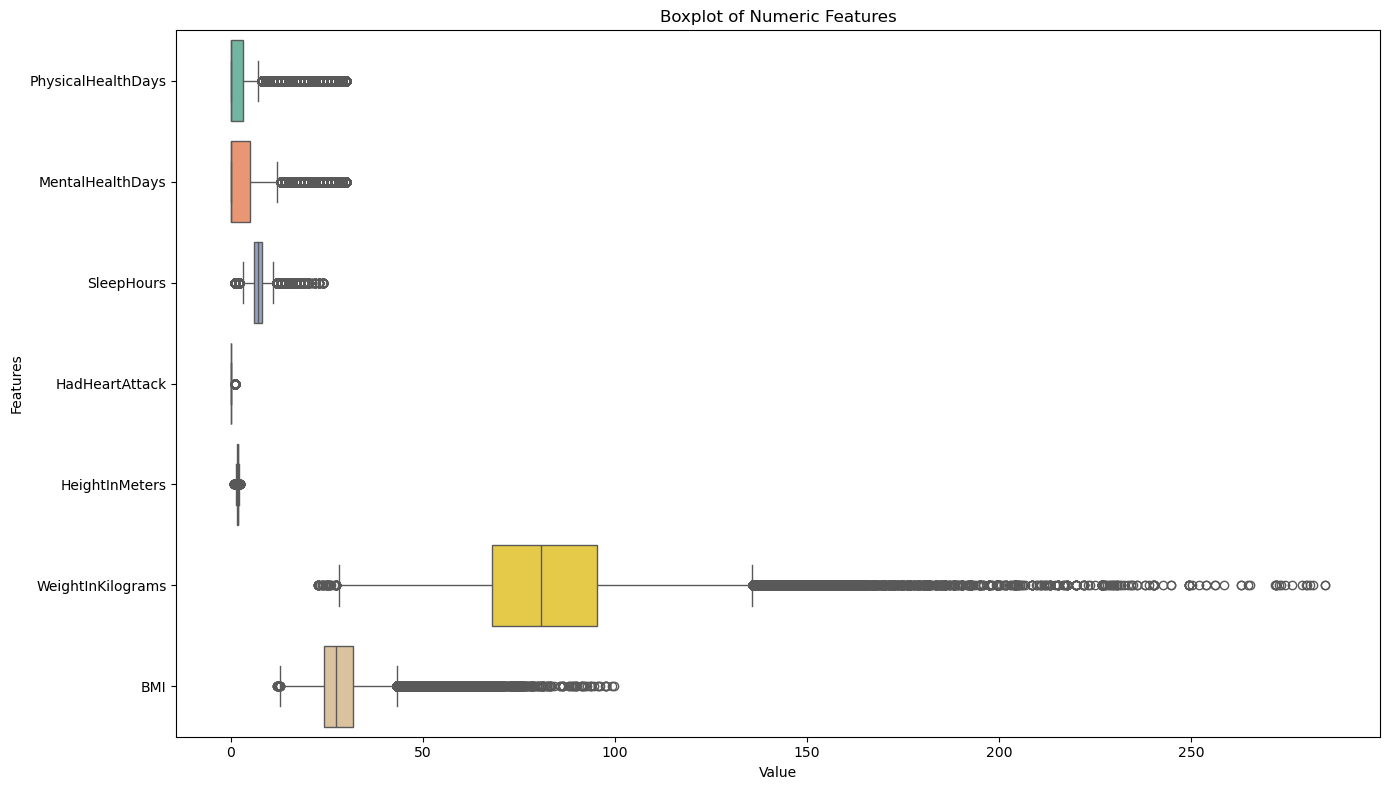

In [22]:
# boxplots for the numeric features to visualize their distributions and identify any outliers.
plt.figure(figsize=(14, 8))

sns.boxplot(data=train_df.select_dtypes(include=['float64', 'int64','int32']), orient="h", palette="Set2")

plt.title('Boxplot of Numeric Features')
plt.xlabel('Value')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


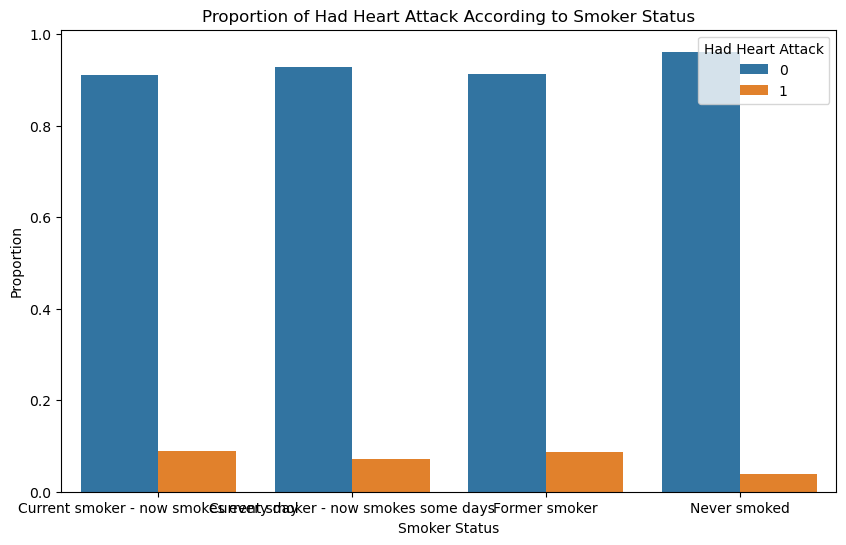

In [23]:
# Calculating the proportion of 'HadHeartAttack' within each 'SmokerStatus' category
grouped_smoker_status = train_df.groupby(['SmokerStatus', 'HadHeartAttack']).size()
proportion_smoker_status = grouped_smoker_status / grouped_smoker_status.groupby(level=0).sum()

# Resetting index to convert multi-index series to dataframe
proportion_smoker_status_df = proportion_smoker_status.reset_index()
proportion_smoker_status_df.columns = ['SmokerStatus', 'HadHeartAttack', 'Proportion']

# Plotting the proportion data
plt.figure(figsize=(10, 6))
sns.barplot(x='SmokerStatus', y='Proportion', hue='HadHeartAttack', data=proportion_smoker_status_df)
plt.title('Proportion of Had Heart Attack According to Smoker Status')
plt.xlabel('Smoker Status')
plt.ylabel('Proportion')
plt.legend(title='Had Heart Attack')
plt.show()


The plot included different categories of smoking status such as current smokers, former smokers, individuals who have never smoked, and unknown status. There appeared to be a noticeable number of heart attack cases among current smokers. This suggests a potential link between active smoking and an increased risk of heart attacks. Former smokers group also showed a significant number of heart attack cases. It's important to note that former smokers might have quit recently or many years ago, and the duration since quitting can influence heart disease risk. The incidence of heart attacks in never smokers group was relatively lower compared to current and former smokers, implying a possible lower risk of heart disease among those who have never smoked. The plot indicates a correlation between smoking status and the occurrence of heart attacks. Current and former smokers showed a higher number of heart attack cases, aligning with medical research that identifies smoking as a significant risk factor for heart disease. The data supports the idea that smoking cessation may be beneficial in reducing heart disease risk, as seen in the difference between current and never smokers.

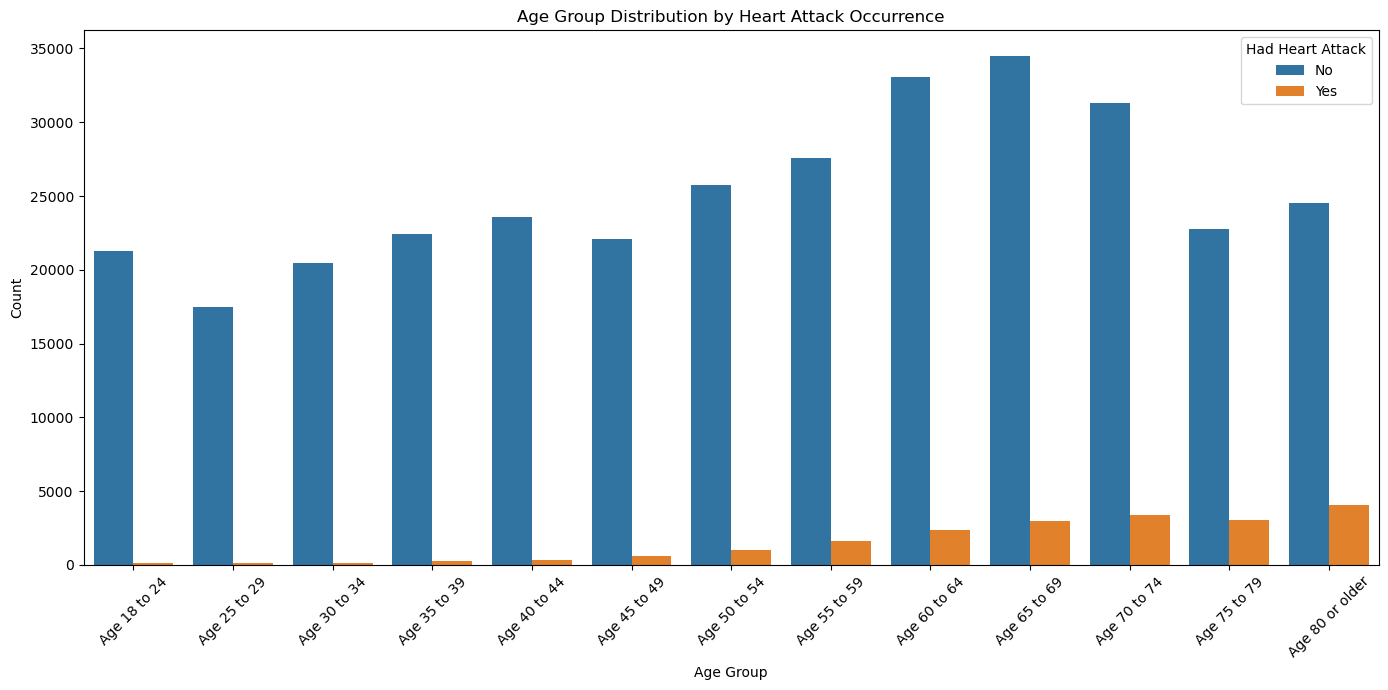

In [24]:
unique_heart_attacks = train_df['HadHeartAttack'].unique()

# Define a function to sort age categories by the lower bound of the age range
def sort_age_categories(age_category):
    # Extract the starting age from the age category string
    age_range = age_category.split('-')[0]
    # Use the starting age as the sorting key (e.g., "65-69" -> 65)
    return int(age_range.split()[1])

# Sort the age categories in ascending order
sorted_age_categories = sorted(train_df['AgeCategory'].dropna().unique(), key=sort_age_categories)

# Filter out rows with NaN in 'AgeCategory' or 'HadHeartAttack'
age_heart_attack_df = train_df.dropna(subset=['AgeCategory', 'HadHeartAttack'])

# Create the plot with sorted age categories and the specified color palette
plt.figure(figsize=(14, 7))
sns.countplot(x='AgeCategory', hue='HadHeartAttack', data=age_heart_attack_df,
              order=sorted_age_categories)
plt.title('Age Group Distribution by Heart Attack Occurrence')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Had Heart Attack', labels=['No', 'Yes'])
plt.tight_layout()
plt.show()

The data includes various age groups, sorted for clarity. There is a noticeable trend where the number of heart attack cases increases with age. Older age categories show a higher count of heart attack cases compared to younger ones. In the younger age groups, the number of heart attack cases is relatively low. There's a significant increase in heart attack cases in the older age groups, which aligns with the general medical understanding that heart attack risk increases with age. The analysis revealed a mix of string and float types in the 'AgeCategory' column, with a small number of float values likely representing missing or improperly recorded data. Age is a crucial factor in predicting heart disease, as evidenced by the increase in heart attack cases with advancing age categories.


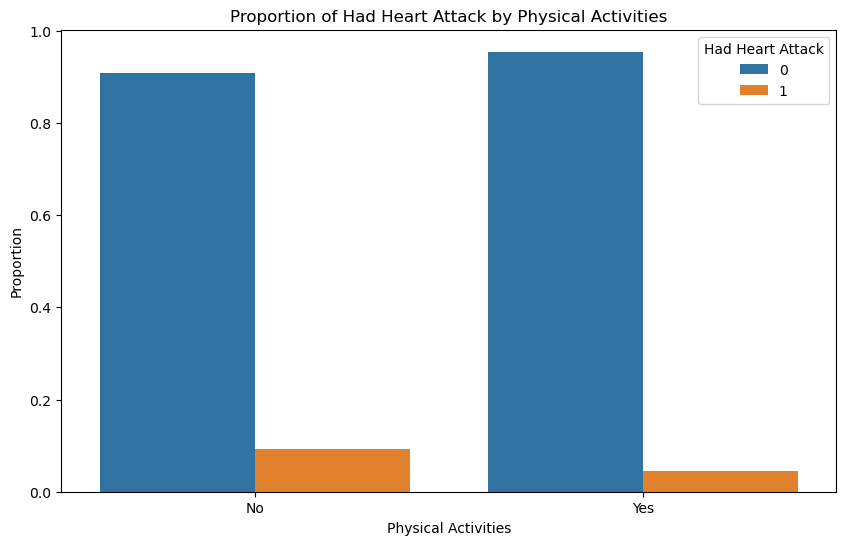

In [25]:
# Calculating the proportion of 'HadHeartAttack' within each 'PhysicalActivities' category
grouped_physical_activities = train_df.groupby(['PhysicalActivities', 'HadHeartAttack']).size()
proportion_physical_activities = grouped_physical_activities / grouped_physical_activities.groupby(level=0).sum()

# Resetting index to convert multi-index series to dataframe
proportion_physical_activities_df = proportion_physical_activities.reset_index()
proportion_physical_activities_df.columns = ['PhysicalActivities', 'HadHeartAttack', 'Proportion']

# Plotting the proportion data
plt.figure(figsize=(10, 6))
sns.barplot(x='PhysicalActivities', y='Proportion', hue='HadHeartAttack', data=proportion_physical_activities_df)
plt.title('Proportion of Had Heart Attack by Physical Activities')
plt.xlabel('Physical Activities')
plt.ylabel('Proportion')
plt.legend(title='Had Heart Attack')
plt.show()


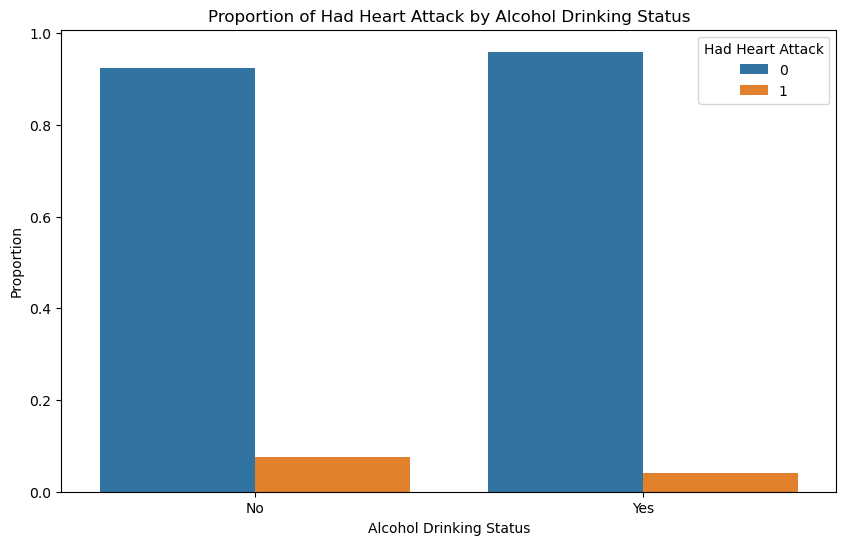

In [26]:
grouped = train_df.groupby(['AlcoholDrinkers', 'HadHeartAttack']).size()
proportion = grouped / grouped.groupby(level=0).sum()

# Resetting index to convert multi-index series to dataframe
proportion_df = proportion.reset_index()
proportion_df.columns = ['AlcoholDrinkers', 'HadHeartAttack', 'Proportion']

# Plotting the proportion data
plt.figure(figsize=(10, 6))
sns.barplot(x='AlcoholDrinkers', y='Proportion', hue='HadHeartAttack', data=proportion_df)
plt.title('Proportion of Had Heart Attack by Alcohol Drinking Status')
plt.xlabel('Alcohol Drinking Status')
plt.ylabel('Proportion')
plt.legend(title='Had Heart Attack')
plt.show()

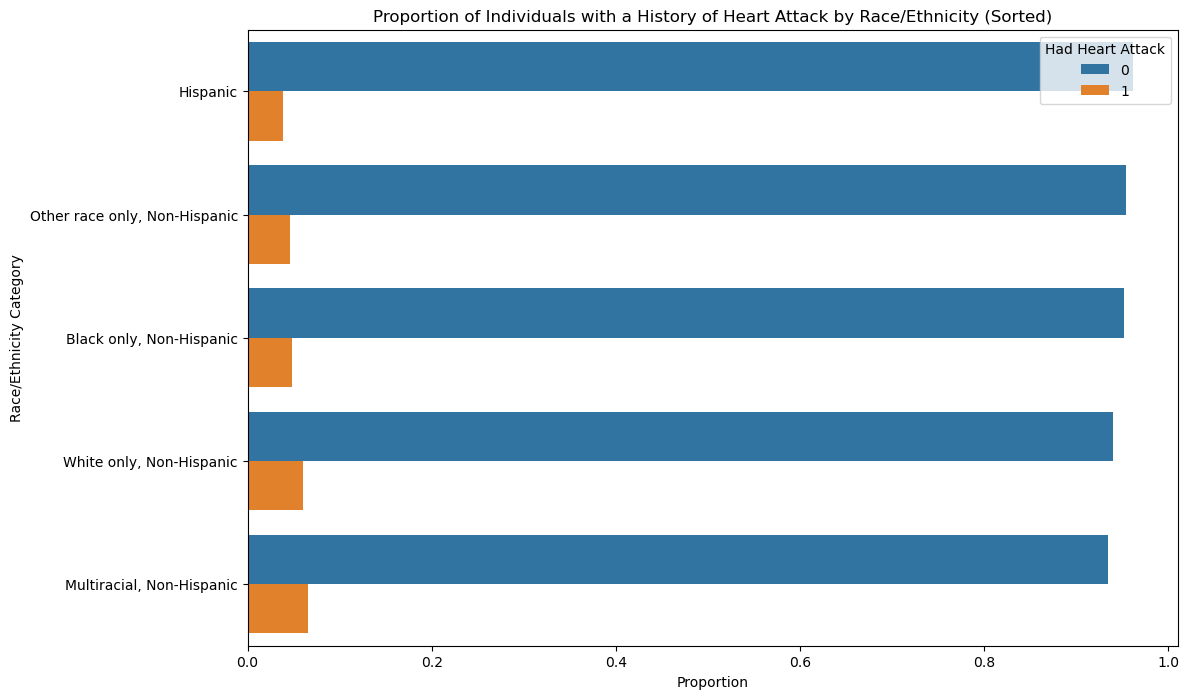

In [27]:
contingency_table_race = pd.crosstab(
    train_df['RaceEthnicityCategory'],
    train_df['HadHeartAttack']
)

# Calculating the proportion of individuals who had a heart attack in each race/ethnicity category
proportion_race = contingency_table_race.div(contingency_table_race.sum(axis=1), axis=0)

# Reshaping the data for plotting
proportion_race_reset = proportion_race.reset_index().melt(id_vars='RaceEthnicityCategory', value_name='Proportion')
proportion_race_reset.columns = ['Race/Ethnicity', 'Had Heart Attack', 'Proportion']

sorted_proportion_race_reset = proportion_race_reset.sort_values(by='Proportion', ascending=False)

# Plotting the sorted bar chart
plt.figure(figsize=(12, 8))
sns.barplot(x='Proportion', y='Race/Ethnicity', hue='Had Heart Attack', data=sorted_proportion_race_reset)
plt.title('Proportion of Individuals with a History of Heart Attack by Race/Ethnicity (Sorted)')
plt.xlabel('Proportion')
plt.ylabel('Race/Ethnicity Category')
plt.legend(title='Had Heart Attack')
plt.show()


This chart illustrates the proportion of individuals who have had a heart attack within different racial and ethnic categories, sorted by increasing porportion of had heart attack. This plot shows tha Multiracial has the highest porportion of people who had heart attack while White only following closely at the second place.

We could do a Chi-Square Test of Independence to determine if the difference between the distribution of heart attack occurrences across different racial groups is statically significant.

Null Hypothesis (H₀): There is no association between race/ethnicity and the occurrence of heart attacks. This implies that the proportion of heart attack occurrences is the same across different racial/ethnic groups.

Alternative Hypothesis (H₁): There is an association between race/ethnicity and the occurrence of heart attacks. This suggests that the likelihood of having a heart attack varies across different racial/ethnic groups.

In [28]:
from scipy.stats import chi2_contingency

# Performing the Chi-Square Test of Independence
chi2, p_value, _, _ = chi2_contingency(contingency_table_race)

# Calculating Cramér's V statistic
n = contingency_table_race.sum().sum()  # Total number of observations
min_dim = min(contingency_table_race.shape) - 1  # Minimum dimensionality
cramers_v = np.sqrt(chi2 / (n * min_dim))

chi2, p_value, cramers_v


(378.1417747933005, 1.4671432417231816e-80, 0.03321828807104802)

In [29]:
contingency_table = pd.crosstab(
    train_df['RaceEthnicityCategory'],
    train_df['HadHeartAttack']
)

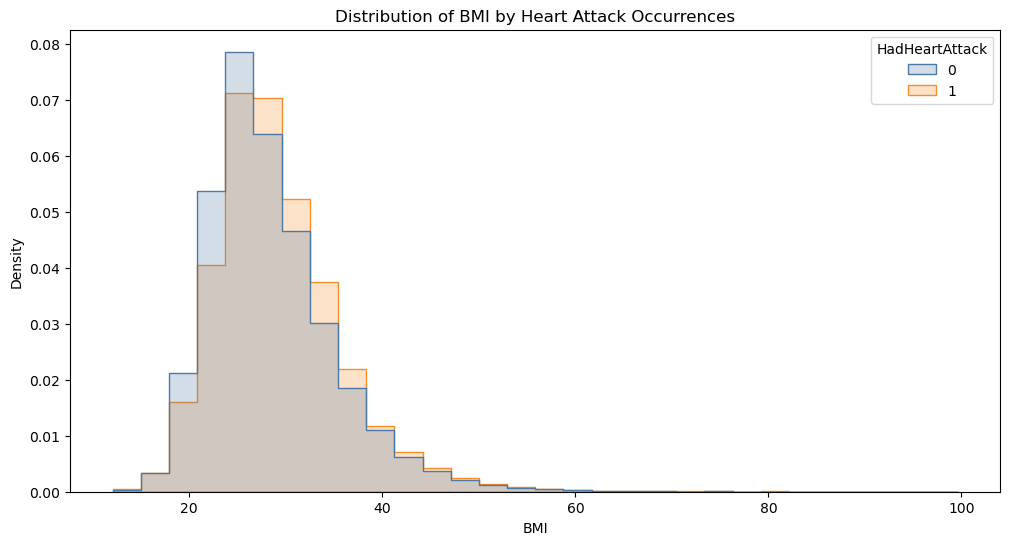

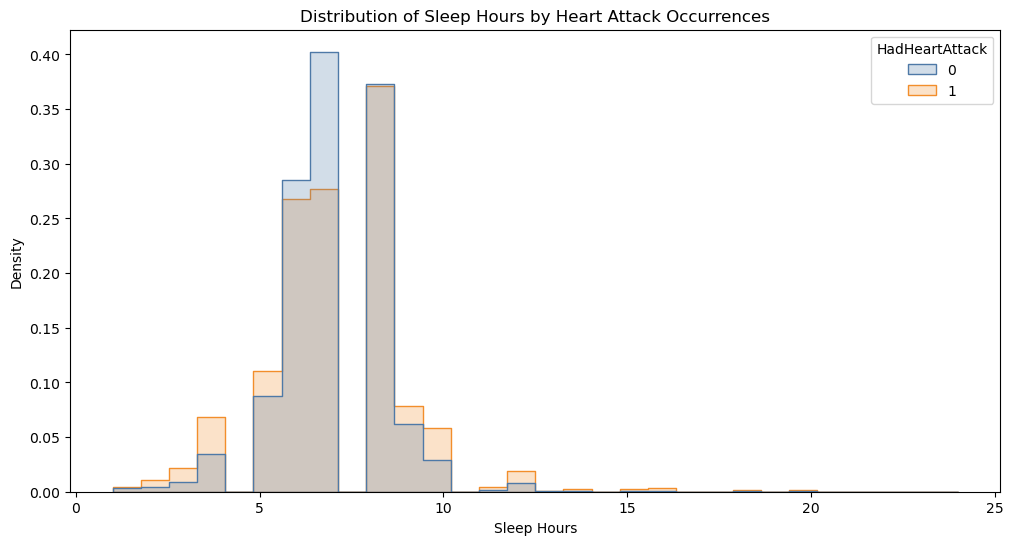

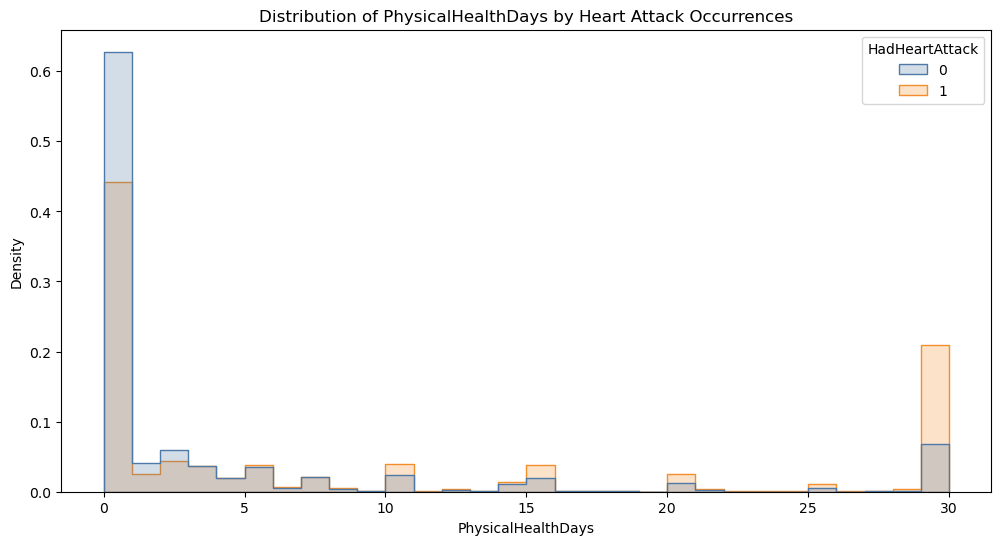

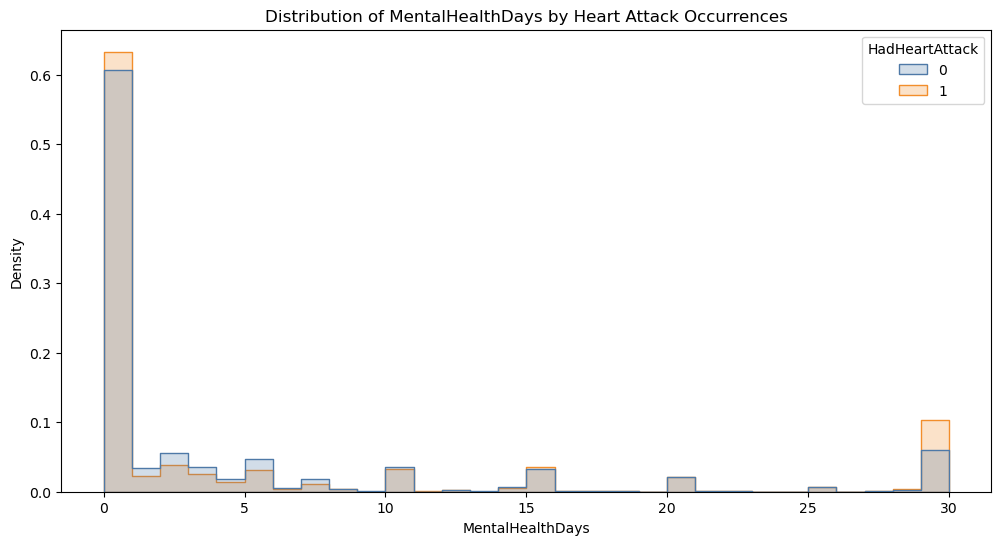

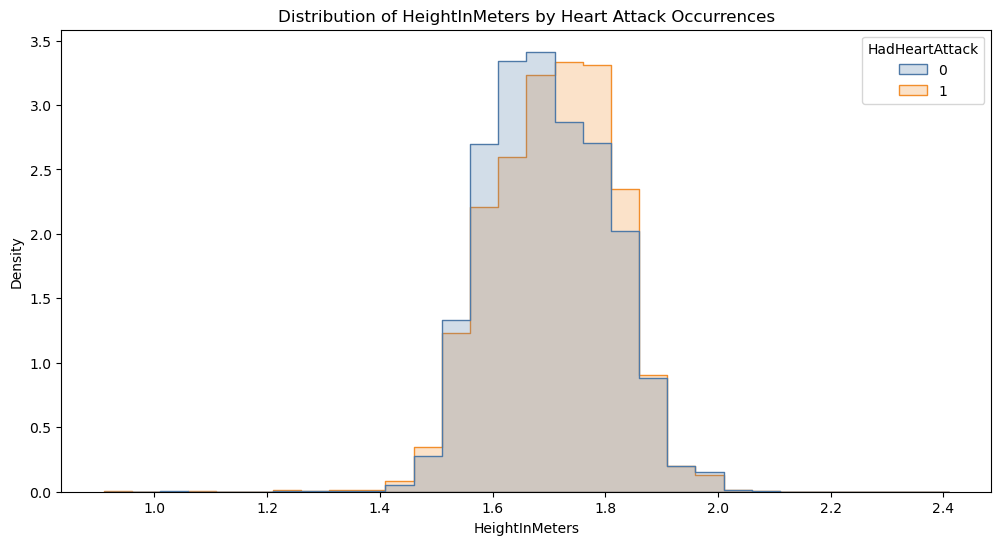

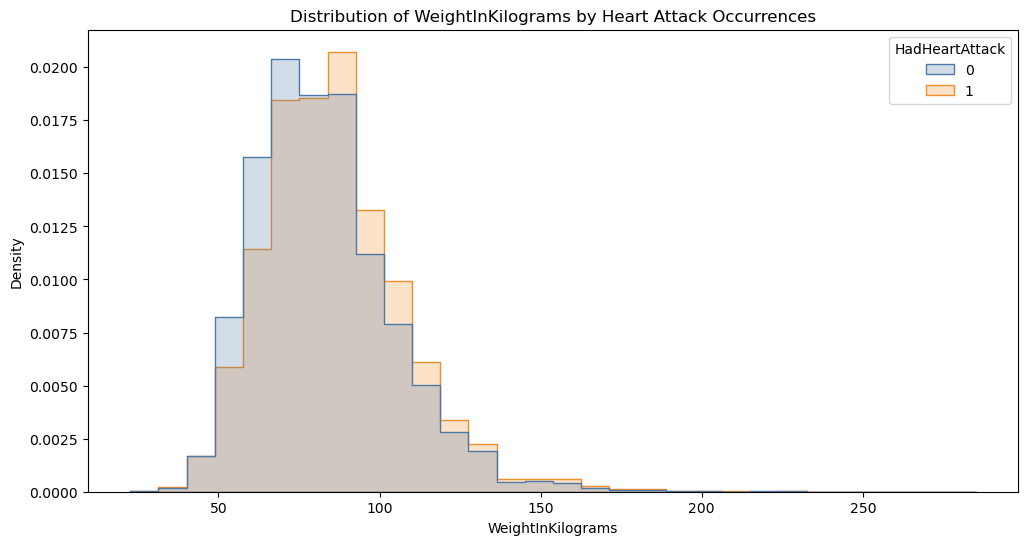

In [30]:
custom_palette = ["#4E79A7", "#F28E2B"]

# Histogram for BMI by HadHeartAttack with distinct colors
plt.figure(figsize=(12, 6))
sns.histplot(data=train_df, x='BMI', hue='HadHeartAttack', element='step', stat='density', common_norm=False, bins=30, palette=custom_palette)
plt.title('Distribution of BMI by Heart Attack Occurrences')
plt.xlabel('BMI')
plt.ylabel('Density')
plt.show()

# Histogram for Sleep Hours by HadHeartAttack with distinct colors
plt.figure(figsize=(12, 6))
sns.histplot(data=train_df, x='SleepHours', hue='HadHeartAttack', element='step', stat='density', common_norm=False, bins=30, palette=custom_palette)
plt.title('Distribution of Sleep Hours by Heart Attack Occurrences')
plt.xlabel('Sleep Hours')
plt.ylabel('Density')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data=train_df, x='PhysicalHealthDays', hue='HadHeartAttack', element='step', stat='density', common_norm=False, bins=30, palette=custom_palette)
plt.title('Distribution of PhysicalHealthDays by Heart Attack Occurrences')
plt.xlabel('PhysicalHealthDays')
plt.ylabel('Density')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data=train_df, x='MentalHealthDays', hue='HadHeartAttack', element='step', stat='density', common_norm=False, bins=30, palette=custom_palette)
plt.title('Distribution of MentalHealthDays by Heart Attack Occurrences')
plt.xlabel('MentalHealthDays')
plt.ylabel('Density')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data=train_df, x='HeightInMeters', hue='HadHeartAttack', element='step', stat='density', common_norm=False, bins=30, palette=custom_palette)
plt.title('Distribution of HeightInMeters by Heart Attack Occurrences')
plt.xlabel('HeightInMeters')
plt.ylabel('Density')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data=train_df, x='WeightInKilograms', hue='HadHeartAttack', element='step', stat='density', common_norm=False, bins=30, palette=custom_palette)
plt.title('Distribution of WeightInKilograms by Heart Attack Occurrences')
plt.xlabel('WeightInKilograms')
plt.ylabel('Density')
plt.show()

1. BMI: The first histogram indicates that there are differences in the distribution of BMI between those who have had a heart attack and those who have not. The distribution for those who had a heart attack (indicated by '1') tends to have a higher BMI. This suggests that BMI could be a relevant feature for predicting heart attack occurrences because it appears that individuals with a higher BMI have a higher density of heart attack occurrences.

2. PhysicaHealthDays: The histogram indicates that individuals who had more days in poor physical health ("PhysicalHealthDays") also had a higher incidence of heart attacks. This feature shows a clear difference in distribution between those who had a heart attack and those who did not, making it a relevant factor for predicting heart attack occurrences in the model.

3. WeightInKilograms: The histogram for "WeightInKilograms" shows some differences in distribution between individuals who have had a heart attack and those who have not, particularly at higher weights. There is a noticeable density of heart attack occurrences at higher weight ranges, suggesting that weight could be a relevant feature for predicting heart attack occurrences. 



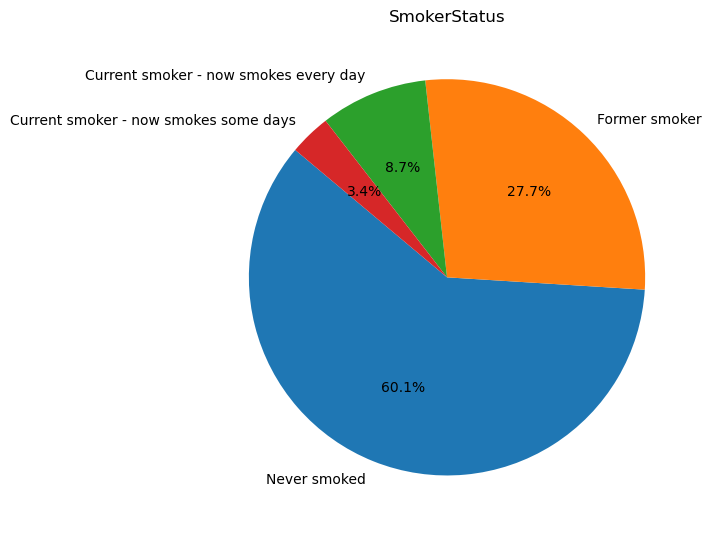

In [31]:
categorical_variables = ['SmokerStatus']
categorical_distributions = train_df[categorical_variables].apply(pd.Series.value_counts).T

# Visualizing the balance across these categorical variables using pie charts
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

for ax, (variable, distribution) in zip(axs.flatten(), categorical_distributions.iterrows()):
    ax.pie(distribution.dropna(), labels=distribution.dropna().index, autopct='%1.1f%%', startangle=140)
    ax.set_title(variable)

for ax in axs.flatten()[len(categorical_variables):]:
    ax.remove()

plt.tight_layout()
plt.show()

The data is imbalanced in terms of its target variable as 94% of people do not have heart attack, which needs to be addressed during the classification modelling. Features including smoker status and physical activities are also demonstrates imbalance, 60% of people never smoked and 76% of them has physical activities.

Text(0.5, 1.0, 'Correlation Heatmap of Selected Features')

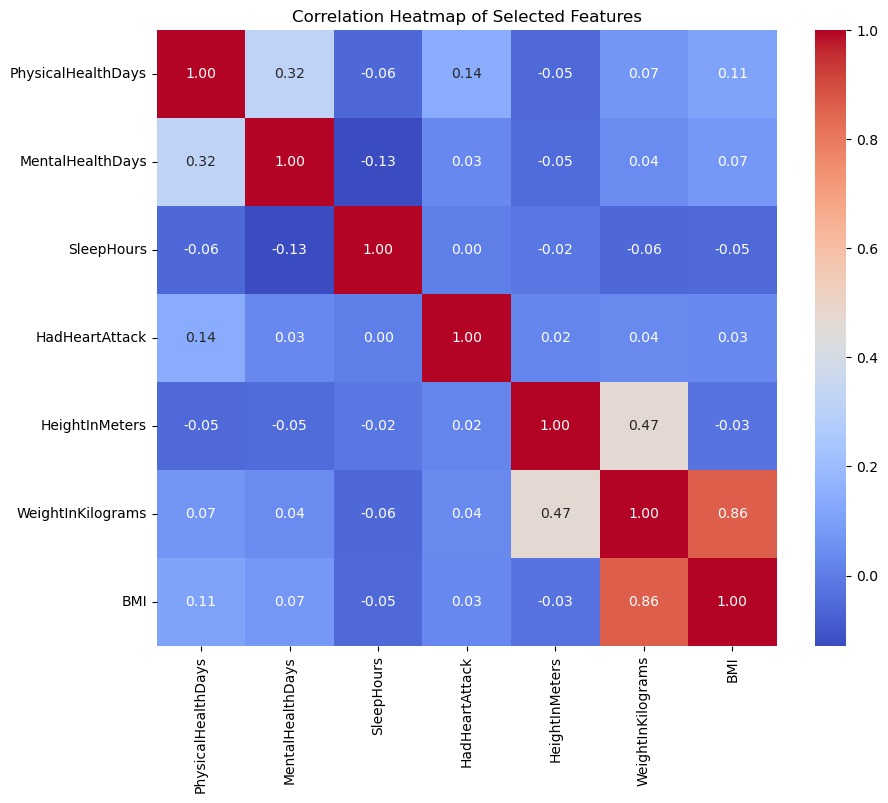

In [32]:
# Selecting numeric features for the correlation plot for further feature selection
data_numeric = train_df.copy()
data_numeric = data_numeric.select_dtypes(include=['float64', 'int64'])
correlation_data = data_numeric.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_data, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Selected Features')

PhysicalHealthDays has a positive correlation (0.14) with HadHeartAttack. This suggests that as the number of days with poor physical health increases, so does the likelihood of having had a heart attack. This feature is likely to be a strong predictor in the classification model.

MentalHealthDays shows a very low positive correlation (0.03) with HadHeartAttack, indicating that mental health may not be as strong a predictor for heart attacks as physical health in this dataset.

HeightInMeters and WeightInKilograms have very low positive correlations (0.02 and 0.04, respectively) with HadHeartAttack. However, these features are highly correlated with BMI (0.47 and 0.86, respectively), which suggests redundancy. This is an important consideration for feature selection to avoid multicollinearity for logistic regression.

BMI has a low positive correlation (0.11) with HadHeartAttack, indicating it could be a contributing factor to heart attack risk. However, given its strong correlation with weight, it may be prudent to use either BMI or WeightInKilograms but not both to reduce multicollinearity.

In summary, PhysicalHealthDays appears to be the most relevant feature for predicting heart attacks among the ones analyzed. BMI or WeightInKilograms could also be considered for inclusion in the model, given their correlation with the target variable. However, care should be taken to select between them to avoid multicollinearity. MentalHealthDays and SleepHours show little to no correlation with heart attacks in this dataset and might be omitted from the model.


Feature Preprocessing

In [33]:
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
for feat in categorical_features:
    df_heart_eda[feat] = df_heart_eda[feat].astype('category')
numeric_features = X_train.select_dtypes(include=['float64', 'int64','int32']).columns.tolist()

ordinal_features = ['GeneralHealth', 'AgeCategory','LastCheckupTime', 'SmokerStatus', 'ECigaretteUsage']
mapping_features = ['HadDiabetes', 'CovidPos', 'TetanusLast10Tdap']

for feature in ordinal_features:
    categorical_features.remove(feature)

for feature in mapping_features:
    categorical_features.remove(feature)

health_order = ['Poor', 'Fair', 'Good', 'Very good', 'Excellent']
age_order = [
        'Age 18 to 24', 'Age 25 to 29', 'Age 30 to 34', 'Age 35 to 39', 
        'Age 40 to 44', 'Age 45 to 49', 'Age 50 to 54', 'Age 55 to 59', 
        'Age 60 to 64', 'Age 65 to 69', 'Age 70 to 74', 'Age 75 to 79', 
        'Age 80 or older'
    ]
check_order = ['Within past year (anytime less than 12 months ago)','Within past 2 years (1 year but less than 2 years ago)','Within past 5 years (2 years but less than 5 years ago)','5 or more years ago']
smoking_order = ['Never smoked', 'Former smoker', 'Current smoker - now smokes every day','Current smoker - now smokes some days']
ecigg_order = ['Never used e-cigarettes in my entire life', 'Not at all (right now)', 'Use them some days', 'Use them every day']

# Define mappings for categorical features
had_diabetes_mapping = {'Yes': 'Yes', 'No': 'No', 'No, pre-diabetes or borderline diabetes': 'No', 'Yes, but only during pregnancy (female)': 'Yes'}
covid_pos_mapping = {'Yes': 'Yes', 'No': 'No', 'Tested positive using home test without a health professional': 'Yes'}
tetanus_last10tdap_mapping = {'Yes, received tetanus shot but not sure what type': 'Yes', 'No, did not receive any tetanus shot in the past 10 years': 'No', 'Yes, received Tdap': 'Yes', 'Yes, received tetanus shot, but not Tdap': 'Yes'}


ordinal_categories = [health_order, age_order, check_order, smoking_order, ecigg_order]

def map_and_encode(df, mapping):
    mapped_df = df.apply(lambda col: col.map(mapping))
    encoder = LabelEncoder()
    encoded_df = mapped_df.apply(encoder.fit_transform)
    return encoded_df

# Create function transformers for mapping and encoding values
had_diabetes_transformer = FunctionTransformer(map_and_encode, kw_args={'mapping': had_diabetes_mapping}, validate=False)
covid_pos_transformer = FunctionTransformer(map_and_encode, kw_args={'mapping': covid_pos_mapping}, validate=False)
tetanus_last10tdap_transformer = FunctionTransformer(map_and_encode, kw_args={'mapping': tetanus_last10tdap_mapping}, validate=False)

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="infrequent_if_exist", drop='if_binary'))
])

ordinal_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ordinal", OrdinalEncoder(categories=ordinal_categories)),
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
        ("ord", ordinal_transformer, ordinal_features),
        ("map_had_diabetes", had_diabetes_transformer, ['HadDiabetes']),
        ("map_covid_pos", covid_pos_transformer, ['CovidPos']),
        ("map_tetanus_last10tdap", tetanus_last10tdap_transformer, ['TetanusLast10Tdap'])
    ],
    remainder='passthrough'
)

#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.applymap.html


Dropped rows with missing HadHeartAttack values and converted this column from 'Yes'/'No' to 1/0.

Converted categorical features to 'category' data type for better processing.

Feature Engineering:
Identified ordinal features (like GeneralHealth, AgeCategory) and applied specific mappings to features such as HadDiabetes, CovidPos, TetanusLast10Tdap.

Used a ColumnTransformer to apply different preprocessing steps:
Numerical features: Imputed missing values with the median and scaled.
Categorical features: Imputed missing values with the most frequent category and applied one-hot encoding.
Ordinal features: Imputed missing values with the most frequent category, encoded them based on predefined order, and scaled.

In [34]:
len(X_train.columns) == len(numeric_features) + len(categorical_features) + len(ordinal_features) + len(mapping_features)

True

In [35]:
numeric_features

['PhysicalHealthDays',
 'MentalHealthDays',
 'SleepHours',
 'HeightInMeters',
 'WeightInKilograms',
 'BMI']

In [36]:
categorical_features

['State',
 'Sex',
 'PhysicalActivities',
 'RemovedTeeth',
 'HadAngina',
 'HadStroke',
 'HadAsthma',
 'HadSkinCancer',
 'HadCOPD',
 'HadDepressiveDisorder',
 'HadKidneyDisease',
 'HadArthritis',
 'DeafOrHardOfHearing',
 'BlindOrVisionDifficulty',
 'DifficultyConcentrating',
 'DifficultyWalking',
 'DifficultyDressingBathing',
 'DifficultyErrands',
 'ChestScan',
 'RaceEthnicityCategory',
 'AlcoholDrinkers',
 'HIVTesting',
 'FluVaxLast12',
 'PneumoVaxEver',
 'HighRiskLastYear']

In [37]:
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

Sampling

In [38]:
#oversampler = SMOTE(random_state=42)
#X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train_preprocessed, y_train)

undersampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_preprocessed, y_train)

We chose undersampling over oversampling mainly due to concerns about overfitting and computational efficiency. My dataset is large, making oversampling impractical because it would significantly increase the data size and processing time. Also, I wanted to avoid introducing synthetic data that could make my model overfit. By undersampling, I efficiently balanced the classes without adding complexity or risking the model's generalizability on unseen data.

Feature Selection

In [39]:
# feature_selector = SequentialFeatureSelector(
#     estimator=RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
#     n_features_to_select= int(X_train_preprocessed.shape[1]*0.25),
#     direction='forward',  # or 'backward'
#     scoring=scoring_metric_chosen,
#     cv=3,
#     n_jobs=-1
# )
#taking too long

scoring_metric_chosen = 'roc_auc'

feature_selector = RFECV(ExtraTreesClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight = 'balanced', 
                                              min_impurity_decrease = 0.01), min_features_to_select=int(X_train_preprocessed.shape[1]*0.40),
                         step=7, cv=5, scoring=scoring_metric_chosen)

#feature_selector = SelectFromModel(DecisionTreeClassifier(random_state=42, max_depth=100))
#feature_selector = SelectFromModel(ExtraTreesClassifier(n_estimators=50).fit(X_train_preprocessed, y_train),prefit=True)
#feature_selector = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight = 'balanced', min_impurity_decrease = 0.1),threshold='median')
#feature_selector = SelectFromModel(ExtraTreesClassifier(n_estimators=50, random_state=42), threshold=-np.inf)

#https://towardsdatascience.com/feature-selection-using-random-forest-26d7b747597f
#https://scikit-learn.org/stable/modules/feature_selection.html

I used feature selection to pinpoint the most relevant features for predicting heart attacks, aiming to improve model accuracy and reduce training time. I chose RFECV with an ExtraTreesClassifier because it's robust and handles both feature importance and interactions well.

ExtraTreesClassifier can quickly evaluate the importance of each feature due to its ensemble approach, offering a good balance between performance and computational efficiency. This method helped me eliminate irrelevant features early on, focusing on the most impactful ones for the final model.

In [40]:
X_train_selected = feature_selector.fit_transform(X_train_resampled, y_train_resampled)

In [41]:
selected_mask = feature_selector.get_support()
cat_feats = preprocessor.named_transformers_['cat'].get_feature_names_out()
all_feat_names = numeric_features + list(cat_feats) + ordinal_features + mapping_features

selected_feature_names = [name for name, selected in zip(all_feat_names, selected_mask) if selected]

print("Selected features:", selected_feature_names)

Selected features: ['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'HeightInMeters', 'WeightInKilograms', 'BMI', 'State_Alabama', 'State_Alaska', 'State_Arizona', 'State_Arkansas', 'State_California', 'State_Colorado', 'State_Connecticut', 'State_Delaware', 'State_District of Columbia', 'State_Florida', 'State_Georgia', 'State_Guam', 'State_Hawaii', 'State_Idaho', 'Sex_Male', 'PhysicalActivities_Yes', 'RemovedTeeth_6 or more, but not all', 'RemovedTeeth_All', 'RemovedTeeth_None of them', 'HadAngina_Yes', 'HadStroke_Yes', 'HadCOPD_Yes', 'HadDepressiveDisorder_Yes', 'HadKidneyDisease_Yes', 'HadArthritis_Yes', 'DeafOrHardOfHearing_Yes', 'BlindOrVisionDifficulty_Yes', 'DifficultyConcentrating_Yes', 'DifficultyWalking_Yes', 'DifficultyDressingBathing_Yes', 'DifficultyErrands_Yes', 'ChestScan_Yes', 'RaceEthnicityCategory_Hispanic', 'RaceEthnicityCategory_Multiracial, Non-Hispanic', 'RaceEthnicityCategory_Other race only, Non-Hispanic', 'AlcoholDrinkers_Yes', 'HIVTesting_Yes', 'FluVa

In [42]:
len(all_feat_names)

99

In [43]:
X_train_preprocessed.shape

(353653, 99)

In [44]:
X_test_preprocessed.shape

(88414, 99)

In [45]:
X_test_selected = feature_selector.transform(X_test_preprocessed)

In [46]:
len(selected_feature_names)

50

Dummy Classifier

In [47]:
crossval_scores = {}
hyperparameter_scores = {}
train_scores = {}

In [48]:
dummy_pipeline = Pipeline(steps=[
    ('dummy', DummyClassifier(strategy="stratified", random_state=42))
])

dummy_pipeline.fit(X_train, y_train)
print("Training score:", dummy_pipeline.score(X_train, y_train))
print("Test score:", dummy_pipeline.score(X_test, y_test))

Training score: 0.8926885958835356
Test score: 0.8939647567127378


Selection of Performance Metric

The model shows high accuracy, yet accuracy alone is insufficient for our heart attack prediction task. Accuracy does not fully capture our need to precisely identify individuals at high risk of heart attacks.

Given the critical nature of heart attack predictions, we prioritize minimizing false negatives to ensure that individuals at risk are not overlooked. Therefore, we use the ROC AUC metric, which helps us achieve a balance by effectively measuring the model's ability to distinguish between those who are at risk and those who are not, aiming for a high true positive rate while keeping false positives low.

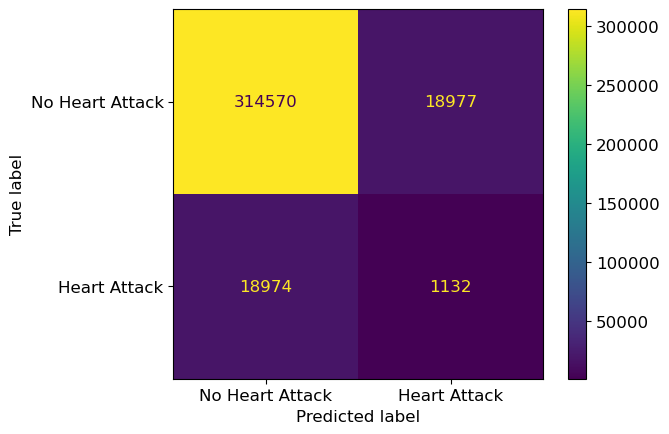

In [49]:
y_train_pred = dummy_pipeline.predict(X_train)

cm = confusion_matrix(y_train, y_train_pred)

plt.rc('font', size=12)
ConfusionMatrixDisplay(cm, display_labels=['No Heart Attack', 'Heart Attack']).plot()

In [50]:
roc_auc = roc_auc_score(y_train, y_train_pred)
print(f"{scoring_metric_chosen}: {roc_auc}")

roc_auc: 0.49970353545305235


Models to Select From

In [51]:
pipelines = {
    'LogisticRegression_balanced': Pipeline([
        ('classifier', LogisticRegression(random_state=42, max_iter=5000, class_weight='balanced', n_jobs=-1))
    ]),
    'LogisticRegression': Pipeline([
        ('classifier', LogisticRegression(random_state=42, max_iter=5000, n_jobs=-1))
    ]),
    'KNeighborsClassifier': Pipeline([
        ('classifier', KNeighborsClassifier(n_jobs=-1))
    ]),
    'DecisionTreeClassifier': Pipeline([
        ('classifier', DecisionTreeClassifier(random_state=42))
    ]),
    'SVC': Pipeline([
        ('classifier', SVC(random_state=42, max_iter=25000, class_weight='balanced'))
    ]),
    'GaussianNB': Pipeline([
        ('classifier', GaussianNB())
    ]),
    'RandomForestClassifier_balanced': Pipeline([
        ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced'))
    ]),
    'RandomForestClassifier': Pipeline([
        ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))
    ]),
}

LogisticRegression_balanced: Linear model with class weights balanced for imbalanced data. Max 5000 iterations, uses all CPU cores.

LogisticRegression: Similar to balanced version without class weight adjustment. Max 5000 iterations, all CPU cores used.

KNeighborsClassifier: Non-linear, votes from k nearest neighbors. Utilizes all CPU cores.

DecisionTreeClassifier: Builds decision trees.

SVC: Support Vector Classifier with balanced class weights, high iteration limit for convergence, addresses imbalanced data.

GaussianNB: Applies Bayes' theorem, suitable for continuous data and class imbalance.

RandomForestClassifier_balanced: Ensemble of decision trees with balanced class weights, parallel computation.

RandomForestClassifier: Ensemble approach without explicit class weight balancing, utilizes parallel processing.

Model Selection and Tuning:

Logistic Regression_balanced

In [52]:
logistic_b_pipeline = pipelines['LogisticRegression_balanced']
cv_scores = cross_val_score(logistic_b_pipeline, X_train_selected, y_train_resampled, cv=5, scoring=scoring_metric_chosen)

print(f"Average CV roc_auc Score: {cv_scores.mean()}")
crossval_scores['LogisticRegressionBalanced'] = cv_scores.mean()

Average CV roc_auc Score: 0.8836846603338152


Hyperparameter Chosen :

In [53]:
# Define a grid of parameters to search over
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Setup the grid search
grid_search_lrb = GridSearchCV(logistic_b_pipeline, param_grid, cv=5, scoring=scoring_metric_chosen, return_train_score=True, verbose=0, n_jobs=-1)

# Fit GridSearchCV
grid_search_lrb.fit(X_train_selected, y_train_resampled)

# Best parameters and scores
print("Best parameters:", grid_search_lrb.best_params_)
print("Best cross-validation roc_auc score:", grid_search_lrb.best_score_)

hyperparameter_scores['LogisticRegressionBalanced'] = grid_search_lrb.best_score_

Best parameters: {'classifier__C': 10}
Best cross-validation roc_auc score: 0.8836888162803612


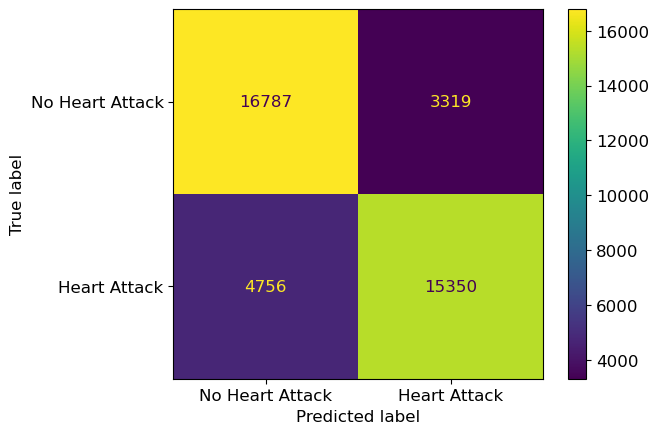

In [54]:
# Predicting on the test set using the best estimator
y_train_pred = grid_search_lrb.best_estimator_.predict(X_train_selected)
cm = confusion_matrix(y_train_resampled, y_train_pred)

# Plotting the confusion matrix
ConfusionMatrixDisplay(cm, display_labels=['No Heart Attack', 'Heart Attack']).plot()
plt.show()
train_scores['LogisticRegressionBalanced'] = roc_auc_score(y_train_resampled, y_train_pred)

Logistic Regression

In [55]:
logistic_pipeline = pipelines['LogisticRegression']
cv_scores = cross_val_score(logistic_pipeline, X_train_selected, y_train_resampled, cv=3, scoring=scoring_metric_chosen)

print(f"Average CV roc_auc Score: {cv_scores.mean()}")
crossval_scores['LogisticRegression'] = cv_scores.mean()

Average CV roc_auc Score: 0.8835953280795907


Hyperparameter Chosen :

In [56]:
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]
}

grid_search_lr = GridSearchCV(logistic_pipeline, param_grid, cv=3, scoring=scoring_metric_chosen, return_train_score=True, verbose=0, n_jobs=-1)

grid_search_lr.fit(X_train_selected, y_train_resampled)

print("Best parameters:", grid_search_lr.best_params_)
print("Best cross-validation roc_auc score:", grid_search_lr.best_score_)
hyperparameter_scores['LogisticRegression'] = grid_search_lr.best_score_

Best parameters: {'classifier__C': 100}
Best cross-validation roc_auc score: 0.8835955061866527


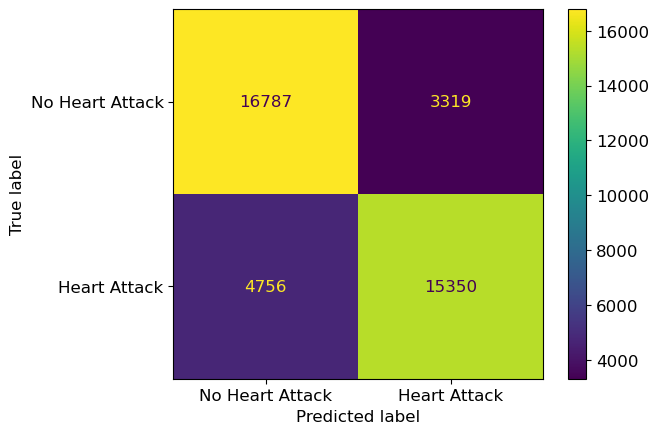

In [57]:

y_train_pred = grid_search_lr.best_estimator_.predict(X_train_selected)  # Ensure X_test_selected is used
cm = confusion_matrix(y_train_resampled, y_train_pred)

# Plotting the confusion matrix
ConfusionMatrixDisplay(cm, display_labels=['No Heart Attack', 'Heart Attack']).plot()
plt.show()
train_scores['LogisticRegression'] = roc_auc_score(y_train_resampled, y_train_pred)

 KNeighborsClassifier

In [58]:
knc_pipeline = pipelines['KNeighborsClassifier']
cv_scores = cross_val_score(knc_pipeline, X_train_selected, y_train_resampled, cv=2, scoring=scoring_metric_chosen)

print(f"Average CV roc_auc Score: {cv_scores.mean()}")
crossval_scores['KNeighborsClassifier'] = cv_scores.mean()

Average CV roc_auc Score: 0.8157686053432376


Hyperparameter Chosen :

In [59]:
param_grid = {
    'classifier__n_neighbors': [3, 5, 7, 10],
    'classifier__weights': ['uniform', 'distance'],
}
random_search_knn = RandomizedSearchCV(knc_pipeline, param_distributions=param_grid, n_iter=1, cv=3, scoring=scoring_metric_chosen, random_state=42, n_jobs=-1)
random_search_knn.fit(X_train_selected, y_train_resampled)

print("Best parameters:", random_search_knn.best_params_)
print("Best cross-validation roc_auc score:", random_search_knn.best_score_)
hyperparameter_scores['KNeighborsClassifier'] = random_search_knn.best_score_

Best parameters: {'classifier__weights': 'distance', 'classifier__n_neighbors': 3}
Best cross-validation roc_auc score: 0.7930788181931495


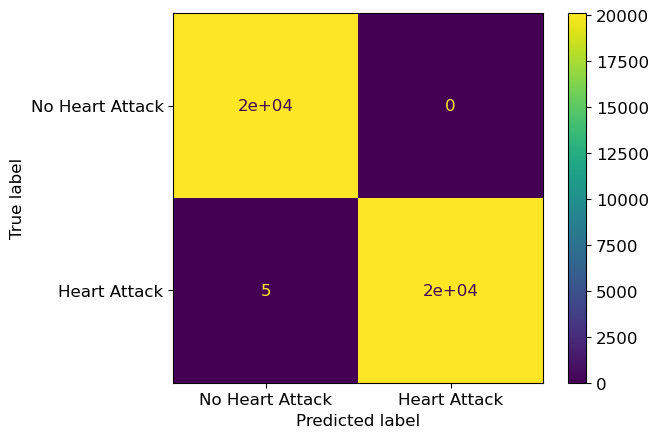

In [60]:
y_train_pred = random_search_knn.best_estimator_.predict(X_train_selected)
cm = confusion_matrix(y_train_resampled, y_train_pred)

ConfusionMatrixDisplay(cm, display_labels=['No Heart Attack', 'Heart Attack']).plot()
plt.show()
train_scores['KNeighborsClassifier'] = roc_auc_score(y_train_resampled, y_train_pred)

DecisionTreeClassifier

In [61]:
dtc_pipeline = pipelines['DecisionTreeClassifier']
cv_scores = cross_val_score(dtc_pipeline, X_train_selected, y_train_resampled, cv=5, scoring=scoring_metric_chosen)

print(f"Average CV roc_auc Score: {cv_scores.mean()}")
crossval_scores['DecisionTreeClassifier'] = cv_scores.mean()

Average CV roc_auc Score: 0.7172706649776888


Hyperparameter Chosen :

In [62]:
param_grid = {
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__min_samples_split': [2, 5, 10],
}

random_search_dtc = RandomizedSearchCV(dtc_pipeline, param_distributions=param_grid, n_iter=3, cv=3, scoring=scoring_metric_chosen, random_state=42, n_jobs=-1)

random_search_dtc.fit(X_train_selected, y_train_resampled)

print("Best parameters:", random_search_dtc.best_params_)
print("Best cross-validation roc_auc score:", random_search_dtc.best_score_)
hyperparameter_scores['DecisionTreeClassifier'] = random_search_dtc.best_score_

Best parameters: {'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': 10}
Best cross-validation roc_auc score: 0.8510928411855246


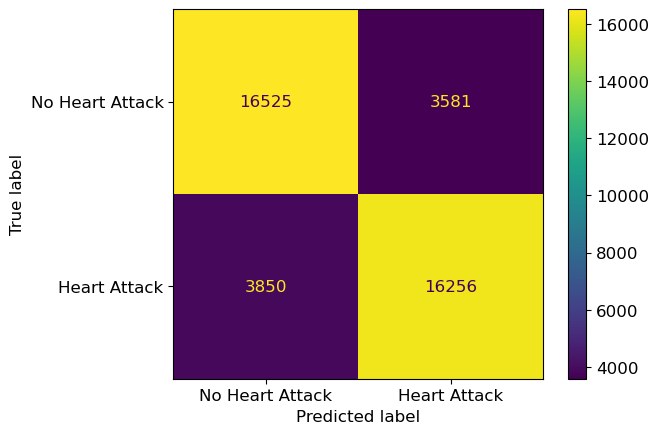

In [63]:
y_train_pred = random_search_dtc.best_estimator_.predict(X_train_selected)
cm = confusion_matrix(y_train_resampled, y_train_pred)

ConfusionMatrixDisplay(cm, display_labels=['No Heart Attack', 'Heart Attack']).plot()
plt.show()
train_scores['DecisionTreeClassifier'] = roc_auc_score(y_train_resampled, y_train_pred)

SVC

In [64]:
svc_pipeline = pipelines['SVC']

cv_scores = cross_val_score(svc_pipeline, X_train_selected, y_train_resampled, cv=3, scoring=scoring_metric_chosen)

print(f"Average CV roc_auc Score: {cv_scores.mean()}")
crossval_scores['SVC'] = cv_scores.mean()

Average CV roc_auc Score: 0.8740383628660074


Hyperparameter Chosen :

In [65]:
param_distributions = {
    'classifier__C': [0.001, 0.01, 0.1],
    'classifier__gamma': np.logspace(-3, 2, 7),
    'classifier__kernel': ['linear', 'rbf'],
}

random_search_svc = RandomizedSearchCV(svc_pipeline, param_distributions=param_distributions, n_iter=5, cv=3, scoring=scoring_metric_chosen, random_state=42, n_jobs=-1)

random_search_svc.fit(X_train_selected, y_train_resampled)

# Best parameters and scores
print("Best parameters:", random_search_svc.best_params_)
print("Best cross-validation roc_auc score:", random_search_svc.best_score_)
hyperparameter_scores['SVC'] = random_search_svc.best_score_

Best parameters: {'classifier__kernel': 'linear', 'classifier__gamma': 100.0, 'classifier__C': 0.01}
Best cross-validation roc_auc score: 0.8827505217572172


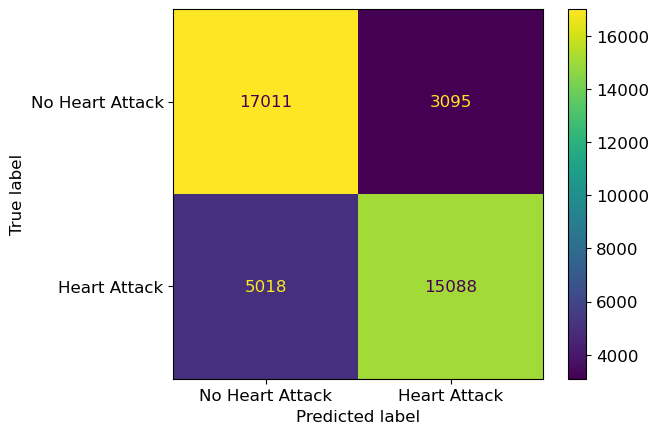

In [66]:
y_train_pred = random_search_svc.best_estimator_.predict(X_train_selected)
cm = confusion_matrix(y_train_resampled, y_train_pred)

ConfusionMatrixDisplay(cm, display_labels=['No Heart Attack', 'Heart Attack']).plot()
plt.show()
train_scores['SVC'] = roc_auc_score(y_train_resampled, y_train_pred)

GaussianNB

In [67]:
#gnb_pipeline = pipelines['GaussianNB']

#cv_scores = cross_val_score(gnb_pipeline, X_train_selected, y_train_resampled, cv=3, scoring=scoring_metric_chosen)

#print(f"Average CV roc_auc Score: {cv_scores.mean()}")


gnb_pipeline = pipelines['GaussianNB']

X_train_selected_dense = X_train_selected.toarray()

cv_scores = cross_val_score(gnb_pipeline, X_train_selected_dense, y_train_resampled, cv=3, scoring=scoring_metric_chosen)

print(f"Average CV roc_auc Score: {cv_scores.mean()}")
crossval_scores['GaussianNB'] = cv_scores.mean()


Average CV roc_auc Score: 0.8426364514566383


Hyperparameter Chosen :

In [68]:
param_distributions = {
    'classifier__var_smoothing': np.logspace(-9, -1, 9)
}

random_search_gnb = RandomizedSearchCV(gnb_pipeline, param_distributions=param_distributions, n_iter=3, cv=3, scoring=scoring_metric_chosen, random_state=42, n_jobs=-1)

random_search_gnb.fit(X_train_selected_dense, y_train_resampled)

print("Best parameters:", random_search_gnb.best_params_)
print("Best cross-validation roc_auc score:", random_search_gnb.best_score_)
hyperparameter_scores['GaussianNB'] = random_search_gnb.best_score_

Best parameters: {'classifier__var_smoothing': 0.01}
Best cross-validation roc_auc score: 0.8521068343746512


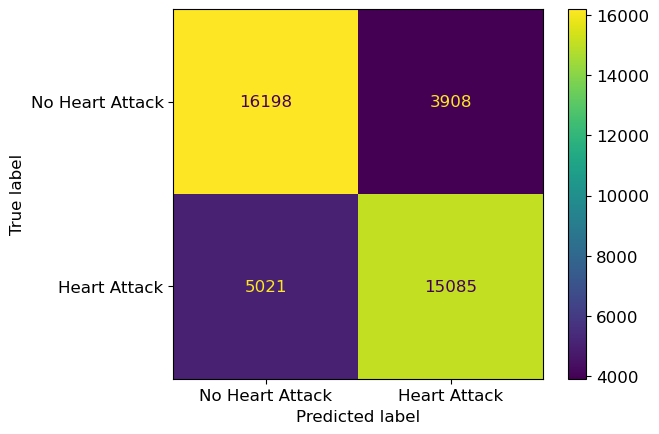

In [69]:
y_train_pred = random_search_gnb.best_estimator_.predict(X_train_selected_dense)
cm = confusion_matrix(y_train_resampled, y_train_pred)

ConfusionMatrixDisplay(cm, display_labels=['No Heart Attack', 'Heart Attack']).plot()
plt.show()
train_scores['GaussianNB'] = roc_auc_score(y_train_resampled, y_train_pred)

RandomForestClassifier_balanced

In [70]:
rfc_b_pipeline = pipelines['RandomForestClassifier_balanced']

cv_scores = cross_val_score(rfc_b_pipeline, X_train_selected, y_train_resampled, cv=5, scoring=scoring_metric_chosen)

print(f"Average CV roc_auc Score: {cv_scores.mean()}")
crossval_scores['RandomForestClassifier_balanced'] = cv_scores.mean()

Average CV roc_auc Score: 0.8788065508266383


Hyperparameter Chosen :

In [71]:
param_grid = {
   'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

grid_search_rfcb = GridSearchCV(rfc_b_pipeline, param_grid=param_grid, cv=2, scoring=scoring_metric_chosen, n_jobs=-1)

grid_search_rfcb.fit(X_train_selected, y_train_resampled)

print("Best parameters:", grid_search_rfcb.best_params_)
print("Best cross-validation roc_auc score:", grid_search_rfcb.best_score_)
hyperparameter_scores['RandomForestClassifier_balanced'] = grid_search_rfcb.best_score_

Best parameters: {'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10}
Best cross-validation roc_auc score: 0.8829095726005398


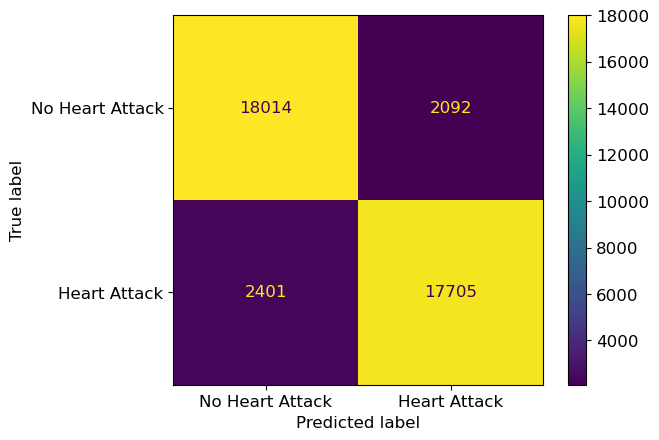

In [72]:

y_train_pred = grid_search_rfcb.best_estimator_.predict(X_train_selected)  # Ensure X_test_selected is used
cm = confusion_matrix(y_train_resampled, y_train_pred)

# Plotting the confusion matrix
ConfusionMatrixDisplay(cm, display_labels=['No Heart Attack', 'Heart Attack']).plot()
plt.show()
train_scores['RandomForestClassifier_balanced'] = roc_auc_score(y_train_resampled, y_train_pred)

RandomForestClassifier

In [73]:
rfc_pipeline = pipelines['RandomForestClassifier']
cv_scores = cross_val_score(rfc_pipeline, X_train_selected, y_train_resampled, cv=3, scoring=scoring_metric_chosen)

print(f"Average CV roc_auc Score: {cv_scores.mean()}")
crossval_scores['RandomForestClassifier'] = cv_scores.mean()

Average CV roc_auc Score: 0.8787361889476079


Hyperparameter Chosen :

In [74]:
param_grid = {
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

grid_search_rfc = GridSearchCV(rfc_pipeline, param_grid=param_grid, cv=3, scoring=scoring_metric_chosen, n_jobs=-1)

grid_search_rfc.fit(X_train_selected, y_train_resampled)

print("Best parameters:", grid_search_rfc.best_params_)
print("Best cross-validation roc_auc score:", grid_search_rfc.best_score_)
hyperparameter_scores['RandomForestClassifier'] = grid_search_rfc.best_score_

Best parameters: {'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10}
Best cross-validation roc_auc score: 0.8832581491476256


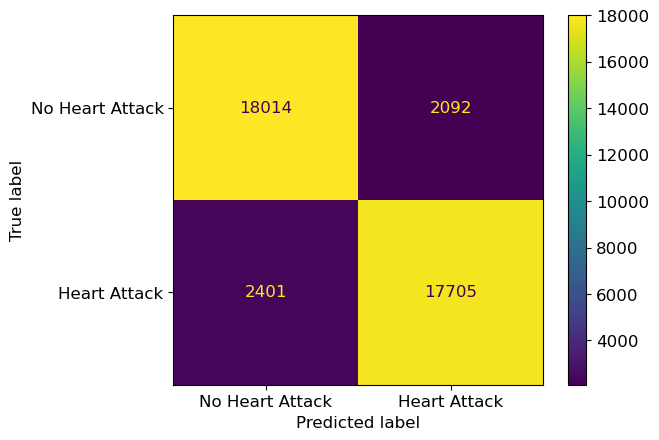

In [75]:

y_train_pred = grid_search_rfc.best_estimator_.predict(X_train_selected)  # Ensure X_test_selected is used
cm = confusion_matrix(y_train_resampled, y_train_pred)

# Plotting the confusion matrix
ConfusionMatrixDisplay(cm, display_labels=['No Heart Attack', 'Heart Attack']).plot()
plt.show()
train_scores['RandomForestClassifier'] = roc_auc_score(y_train_resampled, y_train_pred)

Final Model Selection

In [76]:
#all models train score
model_scores = pd.DataFrame.from_dict(train_scores, orient='index', columns=['Train'])
model_scores['Crossval'] = crossval_scores
model_scores['Hyperparameter'] = hyperparameter_scores
model_scores['Gap'] = abs(model_scores['Train'] - model_scores['Hyperparameter'])
model_scores.sort_values(by='Gap')

,Train,Crossval,Hyperparameter,Gap
RandomForestClassifier,0.888267,0.878736,0.883258,0.005009
RandomForestClassifier_balanced,0.888267,0.878807,0.882910,0.005358
DecisionTreeClassifier,0.815204,0.717271,0.851093,0.035888
GaussianNB,0.777952,0.842636,0.852107,0.074155
LogisticRegression,0.799189,0.883595,0.883596,0.084406
LogisticRegressionBalanced,0.799189,0.883685,0.883689,0.084500
SVC,0.798244,0.874038,0.882751,0.084506
KNeighborsClassifier,0.999876,0.815769,0.793079,0.206797


I picked the RandomForestClassifier because it showed strong and consistent results between training and validation phases, indicating good generalization without overfitting.

The balanced version didn't add much benefit, so I stuck with the standard RandomForest which was slightly better.

DecisionTreeClassifier was overfitting, evident from its large gap between training and validation scores.

GaussianNB and Logistic Regression (balanced or not) were good at generalizing, as seen by their validation scores, but they were not as performant as the RandomForest.

SVC was decent, but not as good as RandomForest, plus it had convergence issues that could complicate deployment.

KNeighborsClassifier performed almost too well on the training set, which was a clear sign of overfitting, making it unreliable for unseen data.

Overall, RandomForest hit the sweet spot between high performance and reliability, which is why it was my model of choice.

In [86]:
final_feature_selector = RFECV(RandomForestClassifier(n_jobs=-1, min_samples_split=grid_search_rfc.best_params_['classifier__min_samples_split'], 
                                                      min_samples_leaf=grid_search_rfc.best_params_['classifier__min_samples_leaf'], 
                                                      random_state=42), step=1, cv=3, 
                               scoring=scoring_metric_chosen, min_features_to_select=int(0.4*X_train_preprocessed.shape[1]))
final_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('sampler', undersampler),
    ('feature_selector', final_feature_selector),
    ('classifier', RandomForestClassifier(n_jobs=-1, min_samples_split=grid_search_rfc.best_params_['classifier__min_samples_split'], 
                                          min_samples_leaf=grid_search_rfc.best_params_['classifier__min_samples_leaf'], 
                                          random_state=42))])

In [78]:
final_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['PhysicalHealthDays',
                                                   'MentalHealthDays',
                                                   'SleepHours',
                                                   'HeightInMeters',
                                                   'WeightInKilograms',
                                                   'BMI']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_fr...
                                                  ['TetanusLast10Tdap'])])),
                ('sampler', RandomUnderSampler(random_state=42)),
                ('feature_selector',
                 RFECV(cv=3,
                       estimator=RandomForestClassifier(min_samples_leaf=4,
                                                        min_samples_split=10,
                                                        n_jobs=-1,
                                                        random_state=42),
                       min_features_to_select=39, scoring='roc_auc')),
                ('classifier',
                 RandomForestClassifier(min_samples_leaf=4,
                                        min_samples_split=10, n_jobs=-1,
                                        random_state=42))])

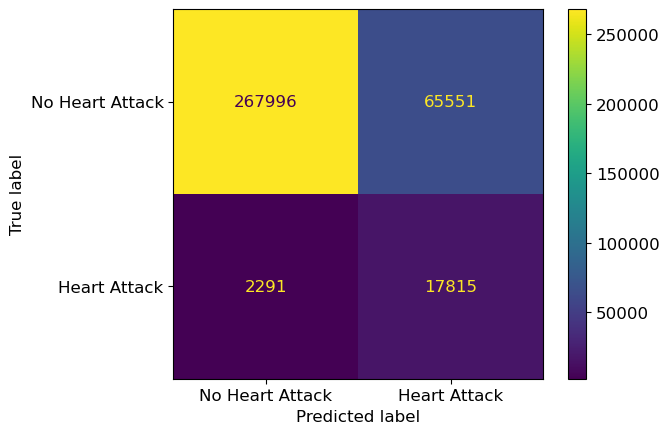

In [79]:
y_train_pred = final_pipeline.predict(X_train)
cm = confusion_matrix(y_train, y_train_pred)

# Plotting the confusion matrix
ConfusionMatrixDisplay(cm, display_labels=['No Heart Attack', 'Heart Attack']).plot()
plt.show()

In [80]:
print("Training roc_auc score:", roc_auc_score(y_train, y_train_pred))

Training roc_auc score: 0.8447634440391152


Test roc_auc score: 0.8013927383537546


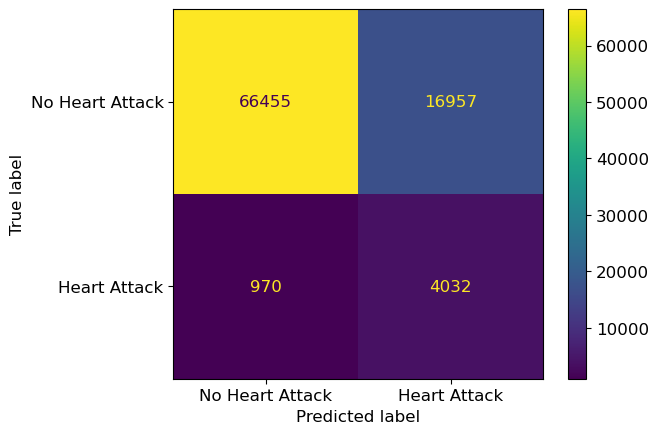

In [82]:
#y_pred = final_pipeline.predict(X_test_preprocessed)
y_pred = final_pipeline.predict(X_test)
print("Test roc_auc score:", roc_auc_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=['No Heart Attack', 'Heart Attack']).plot()
plt.show()

In [83]:
print(classification_report(y_test, y_pred, target_names=['No Heart Attack', 'Heart Attack']))

                 precision    recall  f1-score   support

No Heart Attack       0.99      0.80      0.88     83412
   Heart Attack       0.19      0.81      0.31      5002

       accuracy                           0.80     88414
      macro avg       0.59      0.80      0.60     88414
   weighted avg       0.94      0.80      0.85     88414



Model Performance

The model's ability to correctly identify whether someone will have a heart attack or not is quite good, with an ROC AUC score of about 0.80 for unseen data (test set). This means it's generally good at ranking individuals by their risk of having a heart attack, which is crucial for prioritizing who might need further medical evaluation.

The high recall of 0.81 for heart attack predictions tells us the model is very effective at identifying the majority of actual heart attack cases. In simpler terms, it doesn't miss many individuals who are at risk.

However, the precision for heart attack predictions is 0.19, indicating that when the model predicts a heart attack, it's correct about 19% of the time. This suggests we might be over-alerting, but in the context of heart attacks, we'd rather be safe and check more people than miss someone who is truly at risk.

Overall accuracy is 0.80, meaning that 80% of the model's predictions are correct. For non-heart attack predictions, the model is very reliable (precision of 0.99), meaning there's little chance of false alarms in this group.

Fairness - Fairlearn

        accuracy    recall  precision   roc_auc
Sex                                            
Female  0.847475  0.840365   0.192549  0.844074
Male    0.763683  0.914856   0.228210  0.833199


array([<Axes: title={'center': 'accuracy'}, xlabel='Sex'>,
       <Axes: title={'center': 'recall'}, xlabel='Sex'>,
       <Axes: title={'center': 'precision'}, xlabel='Sex'>,
       <Axes: title={'center': 'roc_auc'}, xlabel='Sex'>], dtype=object)

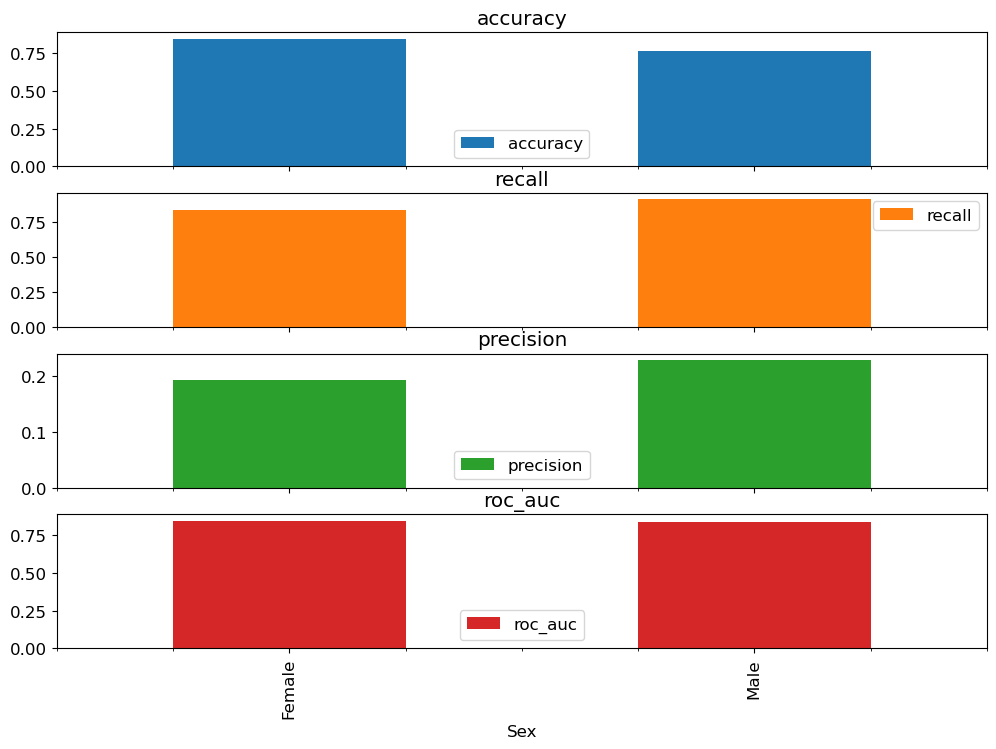

In [84]:
# Define fairness metrics
fairness_metrics = {
    'accuracy': accuracy_score,
    'recall': recall_score,
    'precision': precision_score,
    'roc_auc': roc_auc_score
}

# Define the sensitive feature(s)
sensitive_features_train = X_train['Sex']  # Replace with your actual sensitive feature

# Assess fairness
metric_frame = MetricFrame(
    metrics=fairness_metrics,
    y_true=y_train,
    y_pred=y_train_pred,
    sensitive_features=sensitive_features_train
)

print(metric_frame.by_group)

# Plotting
metric_frame.by_group.plot(kind="bar", figsize=(12, 8), subplots=True)


Fairness Assessment: The performance metrics—accuracy, recall, precision, and ROC AUC—are relatively balanced between females and males. This balance suggests that the model's predictive performance is consistent across genders, indicating no immediate bias based on sex. Therefore, there may not be a need for optimization specifically for fairness concerning gender.
The recall, precision, and roc_auc appear to be equal for both females and males. This is particularly important in medical predictions as it implies the model is equally good at identifying true heart attack cases across genders, minimizing the risk of missed diagnoses.
Overall, the graph suggests that the model's performance is fair and robust across different genders, which is a positive indication for the deployment of the model in diverse populations. It shows that the model's ability to predict heart attacks does not favour one gender over the other, which is crucial for ethical medical applications.


Risk Categorizing

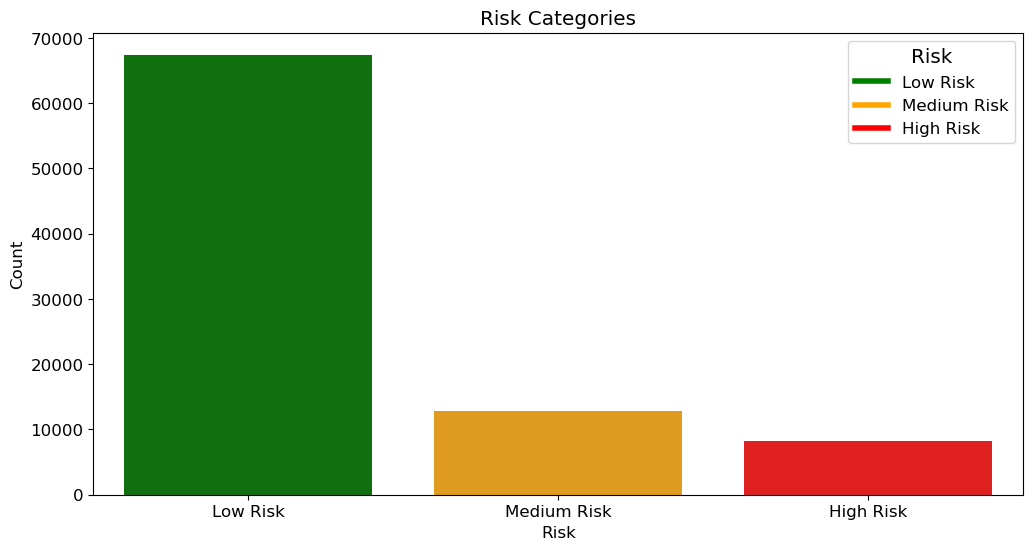

In [85]:
y_pred_prob = final_pipeline.predict_proba(X_test)[:, 1]

# Define risk thresholds based on your domain knowledge or empirical evidence
low_risk_threshold = 0.5
medium_risk_threshold = 0.7

# Classify predictions into different risk categories
risk_categories = ['High Risk' if prob > medium_risk_threshold else 
                   'Medium Risk' if prob > low_risk_threshold else 
                   'Low Risk' for prob in y_pred_prob]

colors = {'Low Risk': 'green', 'Medium Risk': 'orange', 'High Risk': 'red'}

# Plot the risk categories with color
plt.figure(figsize=(12, 6))
sns.countplot(x=risk_categories, hue=risk_categories, palette=colors, dodge=False)

# Create a custom legend
legend_labels = [plt.Line2D([0], [0], color=color, lw=4, label=label) for label, color in colors.items()]
plt.legend(handles=legend_labels, title='Risk', title_fontsize='large')

plt.title('Risk Categories')
plt.xlabel('Risk')
plt.ylabel('Count')
plt.show()
#https://scikit-learn.org/0.17/modules/generated/sklearn.ensemble.RandomForestClassifier.html

This graph categorizes predictions into three risk levels: Low, Medium, and High Risk of heart attack.
It shows the count of individuals in each risk category.
A large number of individuals are categorized as Low Risk, a smaller number as Medium Risk, and even fewer as High Risk.
This categorization helps in prioritizing medical attention or further diagnostic testing based on risk levels.

What more?

Ensemble Learning:
We could explore combining different models to improve our predictions. This isn't just about using multiple models; it's about strategically combining them to cover each other's weaknesses.

Advanced Feature Engineering:
This involves both technical experimentation and consulting with medical experts to understand which data points might be most telling for heart attack risks.

Deep Learning:
 Since we have significant data to train effectively, we can uncover complex patterns using deep learning.